## Оглавление

1. [Просмотр данных из файлов](#start)
2. [Предобработка данных](#preprocessing)
2. [Оценка корректности проведения теста](#correctness_test)
    * [Совпадение времени теста с другими событиями](#2.1)
    * [Пользователи попавшие в обе тестовые группы](#2.2)
    * [Пользователи попавшие в оба теста](#2.3)
    * [Распределение тестовых групп](#2.4)
3. [Исследовательский анализ данных](#eda)
    * [Формирование общей таблицы](#3.1)
    * [Количество событий в выборке](#3.2)
    * [Воронка конверсий по выборкам](#3.3)
4. [Оценка результата А/В-теста](#verification)
6. [Общий вывод](#conclusion)

## Задание

**Контекст**

Наша задача — провести оценку результатов A/B-теста. В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

-	Оценить корректность проведения теста;
-	Проанализировать результаты теста.

Чтобы оценить корректность проведения теста, необходимо проверить:

-	пересечение тестовой аудитории с конкурирующим тестом;
-	совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

**Техническое задание**

 - Название теста: recommender_system_test;
 - группы: А — контрольная, B — новая платёжная воронка;
 - дата запуска: 2020-12-07;
 - дата остановки набора новых пользователей: 2020-12-21;
 - дата остановки: 2021-01-04;
 - аудитория: 15% новых пользователей из региона EU;
 - назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
 - ожидаемое количество участников теста: 6000;
 - ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
  <br>
	<br>а. конверсии в просмотр карточек товаров — событие product_page;
	<br>b. просмотры корзины — product_cart;
	<br>c. покупки — purchase.

**Описание данных**

ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год.
 - name — название маркетингового события;
 - regions — регионы, в которых будет проводиться рекламная кампания;
 - start_dt — дата начала кампании;
 - finish_dt — дата завершения кампании.

final_ab_new_users.csv — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.
 - user_id — идентификатор пользователя;
 - first_date — дата регистрации;
 - region — регион пользователя;
 - device — устройство, с которого происходила регистрация.

final_ab_events.csv — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.
 - user_id — идентификатор пользователя;
 - event_dt — дата и время покупки;
 - event_name — тип события;
 - details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

final_ab_participants.csv — таблица участников тестов.
 - user_id — идентификатор пользователя;
 - ab_test — название теста;
 - group — группа пользователя.


## <a id="start">Просмотр данных из файлов</a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import stats as st
import math as mth
import warnings
%matplotlib inline

In [2]:
# будем игнорировать небольшие предупреждения
warnings.filterwarnings('ignore')
# значения типа float приведем к двум знакам после запятой
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
# загрузка файла с данными
project_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
ab_events = pd.read_csv('/datasets/final_ab_events.csv')
practicipants = pd.read_csv('/datasets/final_ab_participants.csv')

In [4]:
df_list = [project_events, new_users, ab_events, practicipants]

for df in df_list:
	print('Просмотр строк:')
	display(df.sample(10))
	print('Общая информация:')
	display(df.info())
	print('Имена столбцов:')
	display(df.columns)
	print('Дубликаты:')
	display(df.duplicated().sum())
	print('Пропуски:')
	display(df.isna().sum())
	print('Стат. данные:')
	display(df.describe())
	print('-' * 80)

Просмотр строк:


,name,regions,start_dt,finish_dt
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

Имена столбцов:


Index(['name', 'regions', 'start_dt', 'finish_dt'], dtype='object')

Дубликаты:


0

Пропуски:


name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Стат. данные:


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Christmas&New Year Promo,APAC,2020-12-25,2021-01-03
freq,1,4,1,1


--------------------------------------------------------------------------------
Просмотр строк:


,user_id,first_date,region,device
32323,34C60E96F1B6FBC0,2020-12-23,EU,PC
19436,87C9CF23CC3F31F7,2020-12-08,EU,Android
27715,87BBAD560DB275B7,2020-12-09,EU,Android
61573,F1DF95EC1BF887F9,2020-12-20,EU,Mac
39450,4F99C3295CC8B809,2020-12-11,EU,Android
21667,E13F843A9F00566C,2020-12-15,EU,Android
19773,EC6D8450D7ED6FF6,2020-12-08,N.America,iPhone
43573,7FBE01511E275F37,2020-12-18,EU,Android
14259,6BCDA4A4A576D8DF,2020-12-21,EU,Android
21266,95B5928F853C8BD2,2020-12-15,EU,PC


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

Имена столбцов:


Index(['user_id', 'first_date', 'region', 'device'], dtype='object')

Дубликаты:


0

Пропуски:


user_id       0
first_date    0
region        0
device        0
dtype: int64

Стат. данные:


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,D72A72121175D8BE,2020-12-21,EU,Android
freq,1,6290,46270,27520


--------------------------------------------------------------------------------
Просмотр строк:


,user_id,event_dt,event_name,details
97712,D0F2D3E3F0714E29,2020-12-20 22:57:40,product_cart,NaN
363216,EF2FCB7B3ABACFA9,2020-12-20 06:13:00,login,NaN
334409,8251744B16BC1321,2020-12-17 19:50:56,login,NaN
388008,74B19CF82FAC4B21,2020-12-22 19:39:11,login,NaN
138763,F6FD9BD0F761C399,2020-12-10 00:02:06,product_page,NaN
390089,0AF314CE657A8D25,2020-12-22 17:47:03,login,NaN
116212,F1D4F7ACB28627A1,2020-12-25 16:37:26,product_cart,NaN
293486,3243535989409D3E,2020-12-13 17:30:07,login,NaN
359510,FC975780220148B8,2020-12-20 01:44:15,login,NaN
159642,EE0752A48EC29D0F,2020-12-14 15:13:51,product_page,NaN


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

Имена столбцов:


Index(['user_id', 'event_dt', 'event_name', 'details'], dtype='object')

Дубликаты:


0

Пропуски:


user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

Стат. данные:


,details
count,62740.00
mean,23.88
std,72.18
min,4.99
25%,4.99
50%,4.99
75%,9.99
max,499.99


--------------------------------------------------------------------------------
Просмотр строк:


,user_id,group,ab_test
7424,1E03BA54D3886C75,A,interface_eu_test
436,98484FF038267A1C,A,recommender_system_test
9284,59774EAF58D65871,A,interface_eu_test
13147,2CBF38CABDBB7F4F,B,interface_eu_test
2722,368501F66CFDEBFE,A,recommender_system_test
15229,4D6EE7C0E2096C12,A,interface_eu_test
3462,505555B3CCA490C8,A,recommender_system_test
6536,236867C049E784F4,A,recommender_system_test
3968,0F7D49FC184EDCDE,A,recommender_system_test
1700,668400839D594143,A,recommender_system_test


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

Имена столбцов:


Index(['user_id', 'group', 'ab_test'], dtype='object')

Дубликаты:


0

Пропуски:


user_id    0
group      0
ab_test    0
dtype: int64

Стат. данные:


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,0FDFDA0B2DEC2D91,A,interface_eu_test
freq,2,9655,11567


--------------------------------------------------------------------------------


После первого осмотра данных мы увидели:
 - в таблицах нет дублей;
 - в таблице ab_events присутствуют пропуски в столбце details, нужно их изучить;
 - для удобства можно привести значения к нижнему регистру;
 - привести столбцы с датами к соответствующему типу данных;
 - имена столбцов в коррекции не нуждаются.

## <a id="preprocessing">Предобработка данных</a>

**Обработка пропусков**

In [5]:
ab_events

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [6]:
display(ab_events['event_name'].unique())
display(ab_events['details'].unique())

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

array([ 99.99,   9.99,   4.99, 499.99,    nan])

Обзор пропусков показалa, что пропуски обусловлены тем, что кроме стоимости покупок в этой колонке больше не содержится дополнительных данных о событиях.

**Приведение к нижнему регистру**

In [7]:
list_1 = project_events[['name', 'regions']]
list_2 = new_users[['user_id', 'region', 'device']]
list_3 = ab_events[['user_id', 'event_name']]
list_4 = practicipants[['user_id', 'ab_test', 'group']]

def low(df, cols_list):
	for cols in cols_list:
		df[cols] = df[cols].str.lower()
	display(df.head())
	print('-' * 80)

In [8]:
low(project_events, list_1)
low(new_users, list_2)
low(ab_events, list_3)
low(practicipants, list_4)

,name,regions,start_dt,finish_dt
0,christmas&new year promo,"eu, n.america",2020-12-25,2021-01-03
1,st. valentine's day giveaway,"eu, cis, apac, n.america",2020-02-14,2020-02-16
2,st. patric's day promo,"eu, n.america",2020-03-17,2020-03-19
3,easter promo,"eu, cis, apac, n.america",2020-04-12,2020-04-19
4,4th of july promo,n.america,2020-07-04,2020-07-11


--------------------------------------------------------------------------------


,user_id,first_date,region,device
0,d72a72121175d8be,2020-12-07,eu,pc
1,f1c668619dfe6e65,2020-12-07,n.america,android
2,2e1bf1d4c37ea01f,2020-12-07,eu,pc
3,50734a22c0c63768,2020-12-07,eu,iphone
4,e1bddce0dafa2679,2020-12-07,n.america,iphone


--------------------------------------------------------------------------------


,user_id,event_dt,event_name,details
0,e1bddce0dafa2679,2020-12-07 20:22:03,purchase,99.99
1,7b6452f081f49504,2020-12-07 09:22:53,purchase,9.99
2,9cd9f34546df254c,2020-12-07 12:59:29,purchase,4.99
3,96f27a054b191457,2020-12-07 04:02:40,purchase,4.99
4,1fd7660fdf94ca1f,2020-12-07 10:15:09,purchase,4.99


--------------------------------------------------------------------------------


,user_id,group,ab_test
0,d1aba3e2887b6a73,a,recommender_system_test
1,a7a3664bd6242119,a,recommender_system_test
2,dabc14fddfadd29e,a,recommender_system_test
3,04988c5df189632e,a,recommender_system_test
4,482f14783456d21b,b,recommender_system_test


--------------------------------------------------------------------------------


**Изменение типов данных**

In [9]:
list_1 = project_events[['start_dt', 'finish_dt']]
list_2 = new_users[['first_date']]
list_3 = ab_events[['event_dt']]

def date_type(df, cols_list):
	for cols in cols_list:
		df[cols] = pd.to_datetime(df[cols]).dt.date
		df[cols] = df[cols].astype('datetime64[s]')
	display(df.info())
	display(df.head())
	print('-' * 80)

In [10]:
date_type(project_events, list_1)
date_type(new_users, list_2)
date_type(ab_events, list_3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


None

,name,regions,start_dt,finish_dt
0,christmas&new year promo,"eu, n.america",2020-12-25,2021-01-03
1,st. valentine's day giveaway,"eu, cis, apac, n.america",2020-02-14,2020-02-16
2,st. patric's day promo,"eu, n.america",2020-03-17,2020-03-19
3,easter promo,"eu, cis, apac, n.america",2020-04-12,2020-04-19
4,4th of july promo,n.america,2020-07-04,2020-07-11


--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


None

,user_id,first_date,region,device
0,d72a72121175d8be,2020-12-07,eu,pc
1,f1c668619dfe6e65,2020-12-07,n.america,android
2,2e1bf1d4c37ea01f,2020-12-07,eu,pc
3,50734a22c0c63768,2020-12-07,eu,iphone
4,e1bddce0dafa2679,2020-12-07,n.america,iphone


--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


None

,user_id,event_dt,event_name,details
0,e1bddce0dafa2679,2020-12-07,purchase,99.99
1,7b6452f081f49504,2020-12-07,purchase,9.99
2,9cd9f34546df254c,2020-12-07,purchase,4.99
3,96f27a054b191457,2020-12-07,purchase,4.99
4,1fd7660fdf94ca1f,2020-12-07,purchase,4.99


--------------------------------------------------------------------------------


**Итог предобработки:**
 - после изучения пропусков было решено, что они не нуждаются в обработке;
 - все строковые значения были приведены к нижнему регистру;
 - столбцы с датами были приведены к соответствующему типу данных.

## <a id="correctness_test">Оценка корректности проведения теста</a>

### <a id="2.1">Совпадение времени теста с другими событиями</a>

In [11]:
project_events.query('start_dt >= "2020-12-07" & finish_dt <= "2021-01-04"')

,name,regions,start_dt,finish_dt
0,christmas&new year promo,"eu, n.america",2020-12-25,2021-01-03


Тест проводится в одно время с новогодней промо акцией.

### <a id="2.2">Пользователи попавшие в обе тестовые группы</a>

In [12]:
double_group_users = practicipants.groupby(
	'user_id')['ab_test'].nunique().reset_index().query('ab_test > 1')
target_test_users = practicipants.query(
	'ab_test == "recommender_system_test" & user_id in @double_group_users').drop('ab_test', axis = 1)

In [13]:
group_a = list(target_test_users.query('group == "a"')['user_id'])
group_b = list(target_test_users.query('group == "b"')['user_id'])
double_users_count = len([user for user in group_a if user in group_b])
print(f'{double_users_count} пользователей попали в обе группы целевого теста.')

0 пользователей попали в обе группы целевого теста.


### <a id="2.3">Пользователи попавшие в оба теста</a>

In [14]:
double_tests_users = practicipants.groupby('user_id')['ab_test'].nunique().reset_index().query(
	'ab_test > 1')
print(f'{double_tests_users.count().iloc[0]} пользователей попали в оба теста.')

1602 пользователей попали в оба теста.


### <a id="2.4">Распределение тестовых групп</a>

In [15]:
group_a = practicipants.query(
	'ab_test == "recommender_system_test" & group == "a" & user_id not in @double_tests_users')['user_id'].nunique()
group_b = practicipants.query(
	'ab_test == "recommender_system_test" & group == "b" & user_id not in @double_tests_users')['user_id'].nunique()

print(f'Общее кол-во пользователей в тесте {group_a + group_b}')
print(f'Кол-во пользователей в группе А {group_a}')
print(f'Кол-во пользователей в группе Б {group_b}')

Общее кол-во пользователей в тесте 6701
Кол-во пользователей в группе А 3824
Кол-во пользователей в группе Б 2877


Рассмотрим распределение пользователей из целевого теста по районам их проживания.

In [16]:
new_table = practicipants.query('ab_test == "recommender_system_test"')['user_id']
regions_df = pd.merge(new_users, new_table, how='right', on='user_id')
regions_df

,user_id,first_date,region,device
0,d1aba3e2887b6a73,2020-12-07,eu,pc
1,a7a3664bd6242119,2020-12-20,eu,iphone
2,dabc14fddfadd29e,2020-12-08,eu,mac
3,04988c5df189632e,2020-12-14,eu,iphone
4,482f14783456d21b,2020-12-14,eu,pc
...,...,...,...,...
6696,053fb26d6d49eddc,2020-12-10,n.america,android
6697,9d263b8ef15cf188,2020-12-16,n.america,mac
6698,f2fbba33f37dec46,2020-12-18,apac,mac
6699,29c92313a98b1176,2020-12-07,apac,android


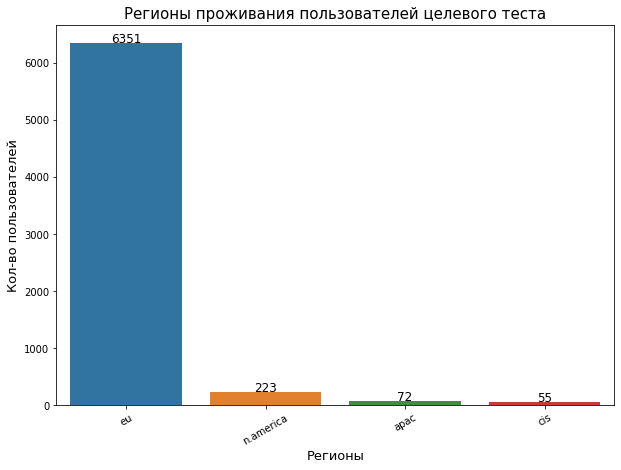

In [17]:
plt.figure(figsize = (10, 7))
ax = sns.barplot(data=regions_df['region'].value_counts().reset_index(), x='index', y='region')
plt.xticks(rotation = 30)
for p in ax.patches:
    plt.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
								fontsize = 12,
                xytext = (0, 4), 
                textcoords = 'offset points')
plt.title('Регионы проживания пользователей целевого теста', size=15)
plt.xlabel('Регионы', size=13)
plt.ylabel('Кол-во пользователей', size=13)
plt.show()

In [18]:
experement_users = regions_df[regions_df['region'] == 'eu']['user_id'].count() / new_users[new_users['region'] == 'eu']['user_id'].count()
print('В выборке целевого теста учавствует {:.2%} пользователей из EU сегмента.'.format(experement_users))

В выборке целевого теста учавствует 13.73% пользователей из EU сегмента.


**По итогам оцеки корректности:**
 - тест проводился во время действия маркетинговой кампании;
 - 1602 пользователя попали в оба параллельно идущих теста;
 - в группе А 3824 человека, в группе Б 2877 человек;
 - недобрали ползователей до целевой отметки в 15%.

По итогам этой части исследования можно сказать, что такое распределение по группам, и параллельно идущая маркетинговая акция могут привести к неудовлетворительным результатам тестирования.

## <a id="eda">Исследовательский анализ данных</a>

### <a id="3.1">Формирвание общей таблицы</a>

Создадим таблицу целевого теста, исключим пользователей, которые учавствовали в двух тестах параллельно, выберем пользователей из сегмента EU и зарегистрировавшихся не более 14 дней назад.

In [19]:
events_per_users = practicipants.query('ab_test == "recommender_system_test" & user_id not in @double_tests_users').merge(
	ab_events, how='inner', on='user_id')
events_per_users = pd.merge(events_per_users, new_users, how='inner', on='user_id')
events_per_users['event_dt'] = pd.to_datetime(events_per_users['event_dt']).dt.date
events_per_users['first_date'] = pd.to_datetime(events_per_users['first_date']).dt.date
events_per_users = events_per_users.query('region == "eu"')
events_per_users = events_per_users[(events_per_users['event_dt'] - events_per_users['first_date']).dt.days < 15]
events_per_users

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device
0,d1aba3e2887b6a73,a,recommender_system_test,2020-12-07,purchase,99.99,2020-12-07,eu,pc
2,d1aba3e2887b6a73,a,recommender_system_test,2020-12-07,product_cart,NaN,2020-12-07,eu,pc
4,d1aba3e2887b6a73,a,recommender_system_test,2020-12-07,product_page,NaN,2020-12-07,eu,pc
6,d1aba3e2887b6a73,a,recommender_system_test,2020-12-07,login,NaN,2020-12-07,eu,pc
8,a7a3664bd6242119,a,recommender_system_test,2020-12-20,product_page,NaN,2020-12-20,eu,iphone
...,...,...,...,...,...,...,...,...,...
23415,80712ed4ea1b52a5,a,recommender_system_test,2020-12-15,product_page,NaN,2020-12-14,eu,android
23416,80712ed4ea1b52a5,a,recommender_system_test,2020-12-20,product_page,NaN,2020-12-14,eu,android
23417,80712ed4ea1b52a5,a,recommender_system_test,2020-12-14,login,NaN,2020-12-14,eu,android
23418,80712ed4ea1b52a5,a,recommender_system_test,2020-12-15,login,NaN,2020-12-14,eu,android


### <a id="3.2">Количество событий в выборке</a>

**Количество событий на одного человека**

In [20]:
print('В стреднем на одного пользователя приходится {:.0f} событий.'.format(events_per_users.groupby('user_id')['event_name'].count().mean()))

В стреднем на одного пользователя приходится 7 событий.


**События в выборке с разбивкой по дням и группам**

In [21]:
res_date = events_per_users.groupby(['event_dt', 'group'])['event_name'].count().reset_index()
res_date.head(10)

,event_dt,group,event_name
0,2020-12-07,a,318
1,2020-12-07,b,356
2,2020-12-08,a,313
3,2020-12-08,b,238
4,2020-12-09,a,371
5,2020-12-09,b,338
6,2020-12-10,a,331
7,2020-12-10,b,249
8,2020-12-11,a,356
9,2020-12-11,b,161


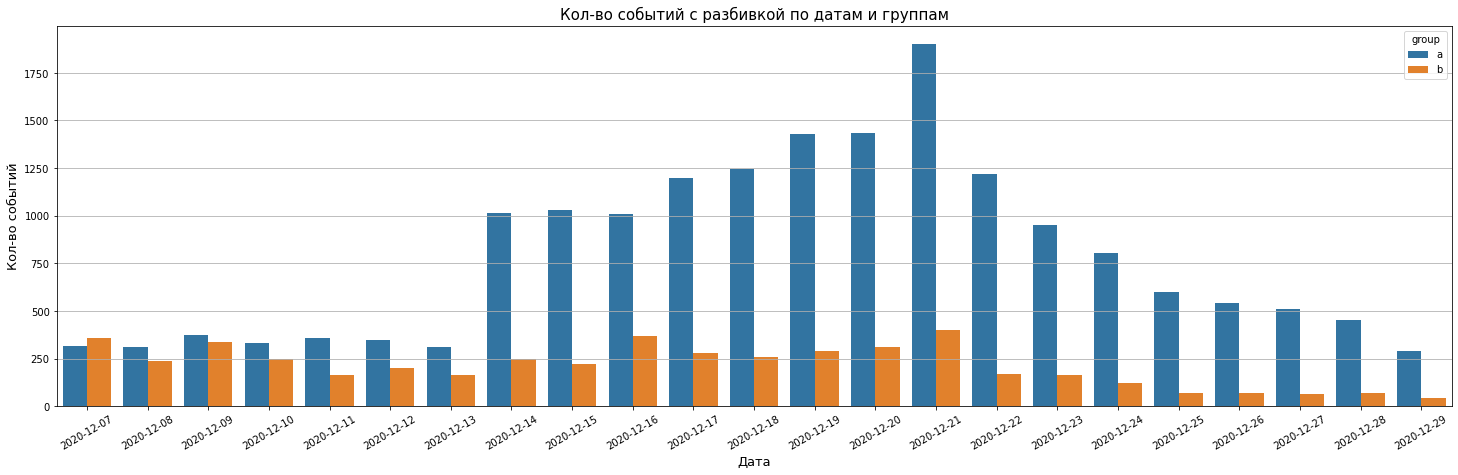

In [22]:
plt.figure(figsize = (25, 7))
plt.grid(True)
sns.barplot(data=res_date, x='event_dt', y='event_name', hue='group')
plt.xticks(rotation = 30)
plt.title('Кол-во событий с разбивкой по датам и группам', size=15)
plt.xlabel('Дата', size=13)
plt.ylabel('Кол-во событий', size=13)
plt.show()

Пик активности группы А наблюдается с 14.12.2020 по 27.12.2020, в это время кол-во событий резко возрастает до ~1800 шт., затем начинает снижаться до отметки ~300 шт.
<br>Группа Б ведет сябя равномерно на всем временном отрезке времени, кол-во событий находится в диапазоне от ~100 до ~400 шт.

**Количество событий в тестовых группах**

In [23]:
res_group = events_per_users.groupby(['event_name', 'group'])['user_id'].nunique().reset_index()
res_group

,event_name,group,user_id
0,login,a,2604
1,login,b,876
2,product_cart,a,782
3,product_cart,b,244
4,product_page,a,1685
5,product_page,b,493
6,purchase,a,833
7,purchase,b,249


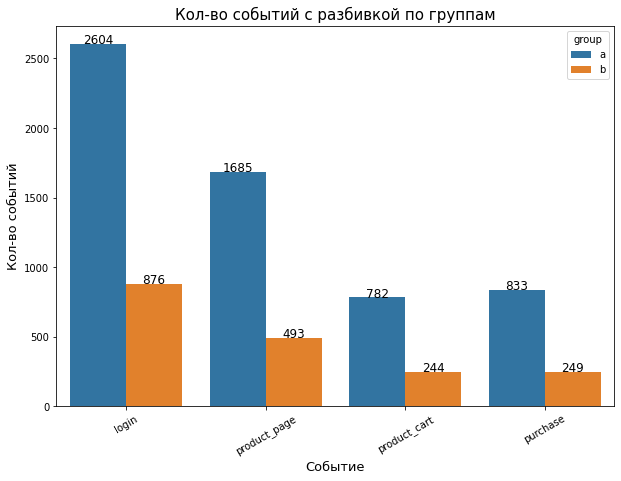

In [24]:
plt.figure(figsize = (10, 7))
ax = sns.barplot(data = res_group, x = 'event_name', y='user_id', hue = 'group', order=['login', 'product_page', 'product_cart', 'purchase'])
plt.xticks(rotation = 30)
for p in ax.patches:
    plt.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
								fontsize = 12,
                xytext = (0, 4), 
                textcoords = 'offset points')
plt.title('Кол-во событий с разбивкой по группам', size=15)
plt.xlabel('Событие', size=13)
plt.ylabel('Кол-во событий', size=13)
plt.show()

### <a id="3.3">Воронка конверсий по выборкам</a>

In [25]:
group_a_conv = (events_per_users.query('group == "a"')
                   .groupby('event_name')
                   .agg({'user_id':'nunique'})
                   .sort_values(by = 'user_id', ascending=False)
                   .reset_index())

group_a_conv = group_a_conv.reindex([0, 1, 3, 2])

group_a_conv

,event_name,user_id
0,login,2604
1,product_page,1685
3,product_cart,782
2,purchase,833


In [26]:
group_b_conv = (events_per_users.query('group == "b"')
                   .groupby('event_name')
                   .agg({'user_id':'nunique'})
                   .sort_values(by = 'user_id', ascending=False)
                   .reset_index())

group_b_conv = group_b_conv.reindex([0, 1, 3, 2])

group_b_conv

,event_name,user_id
0,login,876
1,product_page,493
3,product_cart,244
2,purchase,249


In [27]:
fig = go.Figure()
fig.add_trace(go.Funnel(
	name='group A',
	x=group_a_conv['user_id'],
  y=group_a_conv['event_name'],
	textinfo='value+percent previous'))
fig.add_trace(go.Funnel(
	name='group B',
	x=group_b_conv['user_id'],
  y=group_b_conv['event_name'],
	textinfo='value+percent previous'))

fig.update_layout(
	title='Конверсия событий в группах А и В', autosize=True)
fig.show()

У обоих групп наблюдается резкий спад конверсии при переходе от 'login' на 'product_page', группа А теряет на 9% меньше пользователей.
<br>Далее показатели конверсии распределяются таким образом:
 - при переходе от "product_page" к "product_cart": группа А теряет 19%, группа Б теряет 7%;
 - при переходе от "poduct_cart" к "purchase": группа А получает значение 107%, группа Б 102%
 
Я думаю, что объяснить такой скачек в последнем переходе можно двумя причинами:
 - произошел технический сбой, который исказил информацию в логах;
 - есть прямой путь перехода от "product_page" к "purchase" минуя шаг "poduct_cart".

## <a id="verification">Оценка результата А/В-теста</a>

**Статистически значимые различия в конверсии пользователей по группам**

Проведем сравнение конверсий с помощью Z-критерия Фишера. Установим уровень статистической значимость = 5%, т.к. сравнение будет множественным, сразу введем поправку Бонферрони.

Гипотезы:

Н0: Нет статистически значимой разницы между конверсиями групп
<br>Н1: Есть статистически значимая разница между конверсиями групп

In [28]:
events_per_groups = events_per_users.pivot_table(index = 'event_name', columns = 'group', values = 'user_id', aggfunc = 'nunique')\
                    .sort_values('a', ascending = False)
events_per_groups

group,a,b
event_name,,
login,2604,876
product_page,1685,493
purchase,833,249
product_cart,782,244


In [29]:
alpha = .05 / 4

In [30]:
def z_test(group_1, group_2, events, alpha): 
    purchases1 = events_per_groups.loc[events, group_1]
    purchases2 = events_per_groups.loc[events, group_2]
    n1 = events_per_groups.iloc[0, 0]
    n2 = events_per_groups.iloc[0, 1]
    p1 = purchases1 / n1    
    p2 = purchases2 / n2     
    difference = p1 - p2    
    p_combined = (purchases1 + purchases2) / (n1 + n2)    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / n1 + 1 / n2))                
    distr = st.norm(0, 1)    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    alpha = alpha
    
    print('Переход на страницу', events)
    print('p-value: ',p_value)
   
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: есть статистически значимая разница между конверсиями групп")
    else:
        print("Не получилось отвергнуть нулевую гипотезу: нет статистически значимой разницы между конверсиями групп") 
    print('')

In [31]:
for events in events_per_groups.index:
	z_test('a', 'b', events, alpha)

Переход на страницу login
p-value:  nan
Не получилось отвергнуть нулевую гипотезу: нет статистически значимой разницы между конверсиями групп

Переход на страницу product_page
p-value:  8.195976000324734e-06
Отвергаем нулевую гипотезу: есть статистически значимая разница между конверсиями групп

Переход на страницу purchase
p-value:  0.04864766695042433
Не получилось отвергнуть нулевую гипотезу: нет статистически значимой разницы между конверсиями групп

Переход на страницу product_cart
p-value:  0.2215941567364419
Не получилось отвергнуть нулевую гипотезу: нет статистически значимой разницы между конверсиями групп



По результатам проверки, статистически значимая разница имеется только при переходе на страницу 'product_page', в остальных случаях конверсия пользователей статистически равна.

**Подсчитаем разницу прибыли от продаж между группами**

In [32]:
purchase_per_groups = events_per_users.pivot_table(index = 'event_name', columns = 'group', values = 'details', aggfunc = 'sum')\
                    .sort_values('a', ascending = False)
purchase_result = (purchase_per_groups['b'] / (purchase_per_groups['a'] / 100) - 100).dropna().reset_index()
purchase_result.columns = ['event_name', 'profit_difference']
display(purchase_per_groups)
display(purchase_result)

group,a,b
event_name,,
purchase,57705.01,14268.76
login,0.00,0.00
product_cart,0.00,0.00
product_page,0.00,0.00


,event_name,profit_difference
0,purchase,-75.27


Выручка от покупок в группе Б меньше на 75.27% по сравнению с группой А.
<br>Скорее всего причина такой разницы кроется в весьма неровном распределении между группами.

## <a id="conclusion">Общий вывод</a>

**Проведенный заказчиком тест считаю несостоявшися по следующим причинам:**

 - тест наканчивается 29.12.2020 вместо зявленного 04.01.2021;
 - из сегмента EU в тесте учавствет всего 13.73% пользователей;
 - тест пересекается с маркетинговым событием "christmas&new year promo";
 - 1602 пользователя учавствовали параллельно в двух тестах.
 - не достигнут желаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
	<br>1. конверсия в просмотр "product_page" уменьшилась на 9%;
	<br>2. просмотры "product_cart" увеличилась на 3%;
	<br>3. конверсия в покупок("purchase") увеличилась на 107% для группы А и на 103% для группы Б. Я думаю что эти показатели либо результат технической проблемы, либо пользователи миновали шаг "product_cart".

Необходимо учесть все ошибки проведенного теста, скорректировать механизм контроля, и провести его повторно.

**Рекомендации:**

 - согласовать время проведения теста и маркетинговых акций;
 - настроить систему контроля распределения пользователей, как по группам, так и по параллельно идущим тестам;
 - необходимо доработать систему шагов, от входа до покупки, в настоящем положении невозможно получить адекватный результат;
 - желательно доработать систему контроля территориальной принадлежности под целевой сегмент теста.